In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pathlib 
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

import PT_files.save_load as sl
from DnCNN_NP.layers  import relu, np_Conv2d, np_BatchNorm2d

import time 
from collections import OrderedDict
import pdb

In [4]:
def np_BatchNorm2d(x, weights_dict, prefix, epsilon=1e-5):
    
    batch_start = time.perf_counter()

    gamma = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape(-1, 1, 1)
    beta = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1, 1)
    mean = weights_dict[str(prefix) + 'running_mean'].detach().cpu().numpy().reshape(-1, 1, 1).reshape(-1, 1, 1)
    var = weights_dict[str(prefix) + 'running_var'].detach().cpu().numpy().reshape(-1, 1, 1)
    
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    
    batch_end = time.perf_counter()
    print('Batch takes', batch_end-batch_start, 'seconds')
    
    return output

In [6]:
samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

# 1st Layer
conv_out = np_Conv2d(input_data=samp, weights_dict=weights, prefix='layers.0.0.')
out = relu(conv_out)

# Second Layer
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.1.0.')
# batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.1.1.')
# out = relu(batch_out)

Conv takes 0.590339454007335 seconds
Conv takes 18.449781183036976 seconds


In [7]:
test_sample = samp
test_sample = torch.as_tensor(test_sample)
test_sample = test_sample.to(device)
# sample_torch = torch.from_numpy(sample)
# params = OrderedDict({'weight': weights['layers.0.0.weight'], 'bias': weights['layers.0.0.bias']})
params = OrderedDict({'0.weight': weights['layers.0.0.weight'], '0.bias': weights['layers.0.0.bias'], 
                      '2.weight': weights['layers.1.0.weight'], '2.bias': weights['layers.1.0.bias']})#,
                     #  '3.weight': weights['layers.1.1.weight'], '3.bias': weights['layers.1.1.weight'],
                     #  '3.running_mean': weights['layers.1.1.running_mean'], '3.running_var': weights['layers.1.1.running_var'],
                     # '3.num_batches_tracked': weights['layers.1.1.num_batches_tracked']})

# model = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(inplace=True),
                     nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))#,
                      # nn.BatchNorm2d(num_features=64),
                      #                   nn.ReLU(inplace=True))#,
                      # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))

# params = model.state_dict()
# print(params.keys())
model.to(device)
model.load_state_dict(params)
pytorch_conv_out = model(test_sample)
pytorch_conv_out = pytorch_conv_out.detach().cpu().numpy()

print(np.allclose(conv_out, pytorch_conv_out))

False


In [10]:
pytorch_conv_out.shape

(1, 64, 2000, 2000)

In [11]:
conv_out.shape

(1, 64, 2000, 2000)

In [8]:
print(pytorch_conv_out[0][0][0][:10])
print(conv_out[0][0][0][:10])

[-0.03993676 -0.79065734 -0.5712429  -0.5504655  -0.5256261  -0.49838743
 -0.46664798 -0.46257123 -0.438536   -0.44341552]
[-0.04011539 -0.7907754  -0.5710279  -0.5507196  -0.52562034 -0.4982569
 -0.46658584 -0.46274468 -0.4386391  -0.44338843]


In [9]:
print(pytorch_conv_out.shape)
print(pytorch_conv_out[0][0][0][:10])

(1, 64, 2000, 2000)
[2.4256632 0.5664626 1.1098543 1.1613108 1.222827  1.290285  1.3688896
 1.3789858 1.4385104 1.4264259]


## **1.1 Testing BatchNorm's**

In [10]:
model = nn.BatchNorm2d(num_features=1)
params = model.state_dict()

model.to(device)
model.load_state_dict(params)
pytorch_batch_out = model(test_sample)
pytorch_batch_out = pytorch_batch_out.detach().cpu().numpy()

In [5]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

Shape of test set= (108, 1, 6000, 6000)


In [6]:
from collections import OrderedDict

# Replace the last part of the key that describes what layer it is
# part of and replaces it with empty space
layers_list = [x.replace('weight', '').replace('bias', '').replace('running_mean', '').replace('running_var', '').replace('num_batches_tracked', '') for x in weights.keys()]
# Convert this list which has duplicated elements due to removing
# identifying elements ie. for the first conv layer we had
# layers.0.0.weight & layers.0.0.bias, but now after removing them we
# have layers.0.0 & layers.0.0
# The code below deletes the duplicated elements
layers_list = list(OrderedDict.fromkeys(layers_list))

In [7]:
import numpy as np
from scipy import signal
import time 



# Activations
relu = lambda x: np.maximum(0, x)

def get_indices(input_data, weights_dict, prefix, stride=1, padding=1):
    
    # Get input size
    
    # Checking to see if a single sample or a batch of samples is given.
    # If batch take the batch_size, in_channels, H, and W
    # If single sample is given reshape so the values above can be calculated
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    # Load the weights and biases needed for a convolution
    # then take off gpu memory, move to CPU memory,
    # and lastly transform to numpy
    weight = weights_dict[str(prefix) + 'weight']
    weight = weight.detach().cpu().numpy()
    
    bias = weights_dict[str(prefix) + 'bias']
    bias = bias.detach().cpu().numpy()
    
    # Calculate the kernel size and output channels from
    # the loaded weights from above
    kernel_size = weight[0][0].shape
    output_channels = len(weight)
    
    # Calculations for the output H and W dimensions
    height_out = ((height + (2*padding) - (kernel_size[0] - 1) - 1) / stride) + 1
    height_out = int(height_out)
    width_out = ((width + (2*padding) - (kernel_size[1] - 1) - 1) / stride) + 1
    width_out = int(width_out)
    
    
    # ----Compute matrix of index i----

    # Level 1 vector.
    level1 = np.repeat(np.arange(kernel_size[0]), kernel_size[1])
    # Duplicate for the other channels.
    level1 = np.tile(level1, input_channels)
    # Create a vector with an increase by 1 at each level.
    everyLevels = stride * np.repeat(np.arange(height_out), width_out)
    # Create matrix of index i at every levels for each channel.
    i = level1.reshape(-1, 1) + everyLevels.reshape(1, -1)
    
    # ----Compute matrix of index j----
    
    # Slide 1 vector.
    slide1 = np.tile(np.arange(kernel_size[1]), kernel_size[0])
    # Duplicate for the other channels.
    slide1 = np.tile(slide1, input_channels)
    # Create a vector with an increase by 1 at each slide.
    everySlides = stride * np.tile(np.arange(width_out), height_out)
    # Create matrix of index j at every slides for each channel.
    j = slide1.reshape(-1, 1) + everySlides.reshape(1, -1)
    
    # ----Compute matrix of index d----

    # This is to mark delimitation for each channel
    # during multi-dimensional arrays indexing.
    d = np.repeat(np.arange(input_channels), kernel_size[0] * kernel_size[1]).reshape(-1, 1)
    
    return i, j, d

def im2col(input_data, weights_dict, prefix, stride=1, padding=1):
    """
        Transforms our input image into a matrix.

        Parameters:
        - X: input image.
        - HF: filter height.
        - WF: filter width.
        - stride: stride value.
        - pad: padding value.

        Returns:
        -cols: output matrix.
    """
    
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)

    # Padding
    input_padded = np.pad(input_data, ((0,0), (0,0), (padding, padding), (padding, padding)), mode='constant')
    i, j, d = get_indices(input_data=input_data, weights_dict=weights_dict, prefix=prefix)
    # Multi-dimensional arrays indexing.
    cols = input_padded[:, d, i, j]
    cols = np.concatenate(cols, axis=-1)
    return cols

def np_Conv2d(input_data, weights_dict, prefix):
    """
        Performs a forward convolution.

        Parameters:
        - X : Last conv layer of shape (m, n_C_prev, n_H_prev, n_W_prev).
        Returns:
        - out: previous layer convolved.
    """
    
    conv_start = time.perf_counter()
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 2000 , 2000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)


    output_channels = len(weights_dict[str(prefix) + 'weight']) # num_of_filters
    height_out = int((height + 2 * 1 - 3)/ 1) + 1
    width_out = int((width + 2 * 1 - 3)/ 1) + 1

    X_col = im2col(input_data=input_data, weights_dict=weights_dict, prefix=prefix)
    w_col = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape((output_channels, -1))
    b_col = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1)
    # Perform matrix multiplication.
    out = w_col @ X_col + b_col
    # Reshape back matrix to image.
    out = np.array(np.hsplit(out, batch_size)).reshape((batch_size, output_channels, height_out, width_out))
    
    conv_end = time.perf_counter()
    print('Conv takes', conv_end-conv_start, 'seconds')
    return out

In [20]:
# Layer 1
indices_start = time.perf_counter()
i, j, d = get_indices(input_data=samp, weights_dict=weights, prefix='layers.0.0.')
indices_end = time.perf_counter()
print('Get indices takes:', indices_end-indices_start, 'seconds')

cols_start = time.perf_counter()
cols = im2col(input_data=samp, weights_dict=weights, prefix='layers.0.0.')
cols_end = time.perf_counter()
print('im2col takes:', cols_end-cols_start, 'seconds')

conv_start = time.perf_counter()
out= np_Conv2d(input_data=samp, weights_dict=weights, prefix='layers.0.0.')
conv_end = time.perf_counter()
print('np_Conv2d takes:', conv_end-conv_start, 'seconds')


Get indices takes: 0.11479374096961692 seconds
im2col takes: 0.2867774869664572 seconds
Conv takes 0.5625770220067352 seconds
np_Conv2d takes: 0.5643851879867725 seconds


In [21]:
# Layer 2
indices_start = time.perf_counter()
i, j, d = get_indices(input_data=out, weights_dict=weights, prefix='layers.1.0.')
indices_end = time.perf_counter()
print('Get indices takes:', indices_end-indices_start, 'seconds')

cols_start = time.perf_counter()
cols = im2col(input_data=out, weights_dict=weights, prefix='layers.1.0.')
cols_end = time.perf_counter()
print('im2col takes:', cols_end-cols_start, 'seconds')

conv_start = time.perf_counter()
out= np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.1.0.')
conv_end = time.perf_counter()
print('np_Conv2d takes:', conv_end-conv_start, 'seconds')


Get indices takes: 4.485783719981555 seconds
im2col takes: 16.176846023998223 seconds
Conv takes 18.267302062013187 seconds
np_Conv2d takes: 18.28016663400922 seconds


In [14]:
# Layer 1 takes
ly1_start = time.perf_counter()
output = np_Conv2d(input_data=samp,
                   weights_dict=weights,
                   prefix=layers_list[0])
output = relu(output)
ly1_end = time.perf_counter()
print('Layer 1 takes', ly1_end-ly1_start, 'seconds')

#Layer 2
ly2_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                   weights_dict=weights,
                   prefix=layers_list[1])
output = relu(output)
ly2_end = time.perf_counter()
print('Layer 2 takes', ly2_end-ly2_start, 'seconds')


Conv takes 0.5640038939891383 seconds
Layer 1 takes 0.9337622789898887 seconds
Conv takes 17.65935685200384 seconds
Layer 2 takes 18.036209242010955 seconds


# **1.Testing Whole Model**

In [16]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

Shape of test set= (108, 1, 6000, 6000)


In [17]:
from collections import OrderedDict

# Replace the last part of the key that describes what layer it is
# part of and replaces it with empty space
layers_list = [x.replace('weight', '').replace('bias', '').replace('running_mean', '').replace('running_var', '').replace('num_batches_tracked', '') for x in weights.keys()]
# Convert this list which has duplicated elements due to removing
# identifying elements ie. for the first conv layer we had
# layers.0.0.weight & layers.0.0.bias, but now after removing them we
# have layers.0.0 & layers.0.0
# The code below deletes the duplicated elements
layers_list = list(OrderedDict.fromkeys(layers_list))
# a

In [18]:
# 1st layer
model_start = time.perf_counter()
output = np_Conv2d(input_data=samp,
                   weights_dict=weights,
                   prefix=layers_list[0])

output = relu(output)


for i in range(len(layers_list)-2):
    
    if layers_list[i+1].endswith('0.'):
        
        # conv_start = time.perf_counter()
        output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[i+1])
        conv_end = time.perf_counter()
        # print('Conv Layer', conv_end-conv_start, 'seconds')
        
    elif layers_list[i+1].endswith('1.'):
        
        # batch_start = time.perf_counter()
        output = np_BatchNorm2d(x=output,
                                weights_dict=weights,
                                prefix=layers_list[i+1])
        output = relu(output)
        batch_end = time.perf_counter()
        # print('Batch Layer', batch_end-batch_start, 'seconds')


output = np_Conv2d(input_data=output,
                   weights_dict=weights,
                   prefix=layers_list[-1])

resid_img = samp - output

model_end= time.perf_counter()
print('Total time for 2k by 2k numpy inference takes', model_end-model_start, 'seconds')

Conv takes 0.6273140599951148 seconds
Conv takes 17.643243687984068 seconds
Batch takes 0.5006157399620861 seconds
Conv takes 17.49512257700553 seconds
Batch takes 0.5004311039811 seconds
Conv takes 17.46838224399835 seconds
Batch takes 0.5016922759823501 seconds
Conv takes 17.570970122003928 seconds
Batch takes 0.5003473499673419 seconds
Conv takes 17.67075806297362 seconds
Batch takes 0.5007485750247724 seconds
Conv takes 17.713417714985553 seconds
Batch takes 0.4985075140139088 seconds
Conv takes 17.55334620497888 seconds
Batch takes 0.49822957802098244 seconds
Conv takes 17.47375430702232 seconds
Batch takes 0.5033359109656885 seconds
Conv takes 17.671522987016942 seconds
Batch takes 0.5005127880140208 seconds
Conv takes 17.502229891018942 seconds
Batch takes 0.4991447509964928 seconds
Conv takes 17.62166166503448 seconds
Batch takes 0.4998201159760356 seconds
Conv takes 17.692769229994155 seconds
Batch takes 0.49764770799083635 seconds
Conv takes 17.563749305030797 seconds
Batch t

In [28]:
resid_img.shape

(1, 1, 2000, 2000)

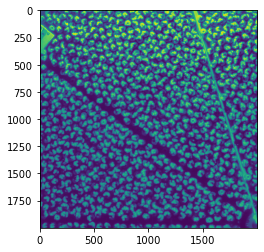

In [29]:
plt.imshow(resid_img[0][0])

Text(0.5, 1.0, 'Numpy Denoised Image')

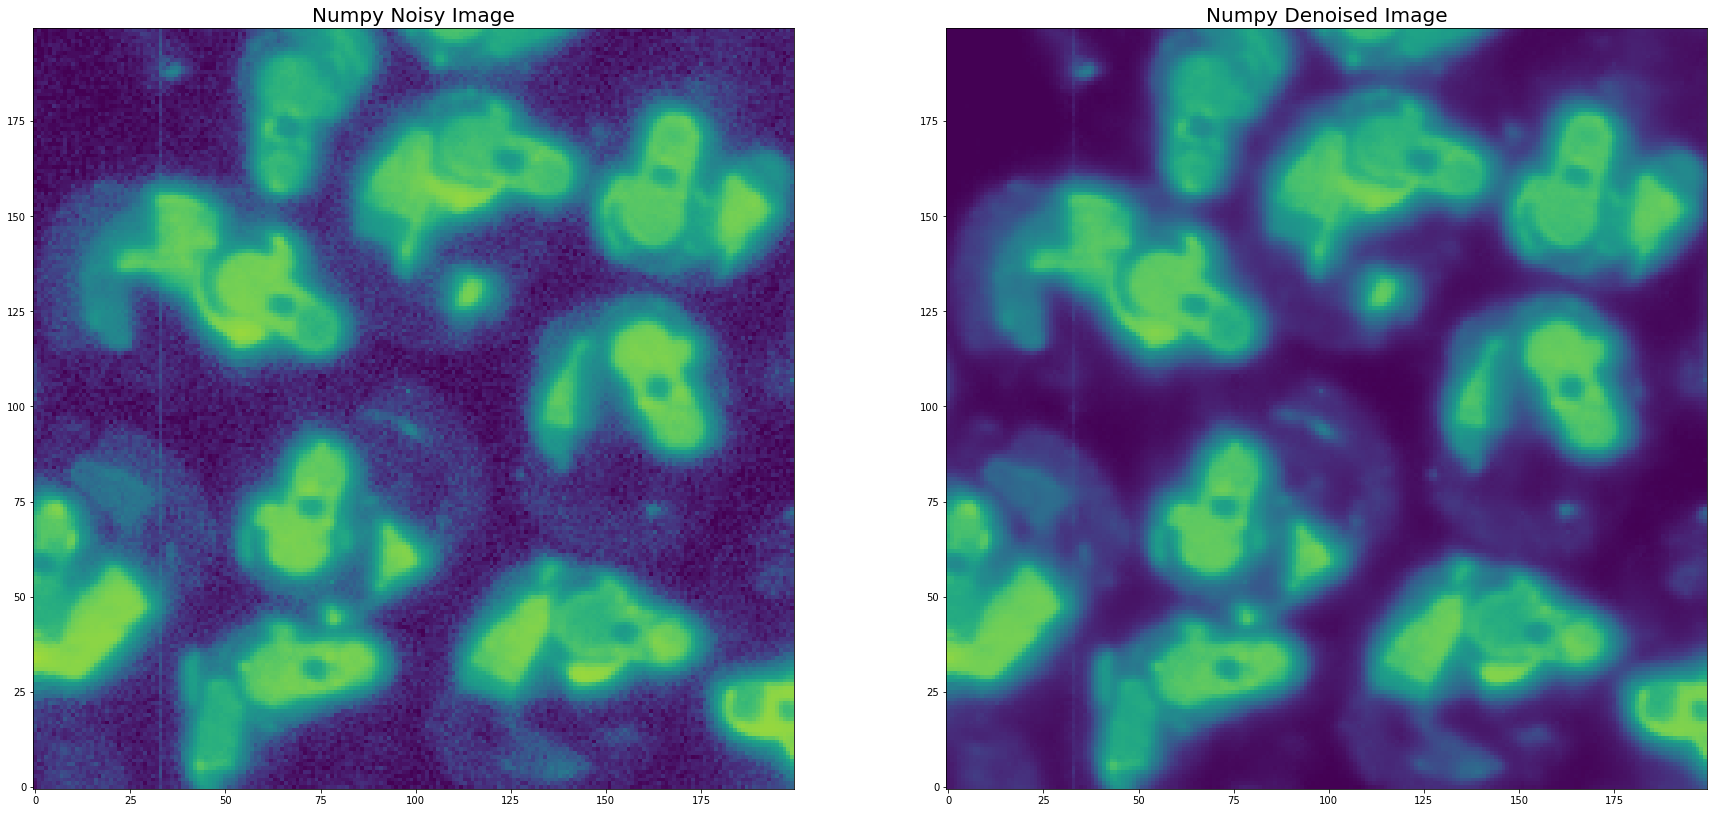

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(30, 26))
vmin, vmax = np.percentile(samp[0][0], (1,99))

# axes[0].imshow(samp[0][0], vmin=vmin, vmax=vmax, origin='lower')
# axes[0].set_title('Input Noisy Image', fontsize=20)
# axes[1].imshow(resid_img[0][0],vmin=vmin, vmax=vmax, origin='lower')
# axes[1].set_title('Numpy Denoised Image', fontsize=20)
axes[0].imshow(samp[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[0].set_title('Numpy Noisy Image', fontsize=20)
axes[1].imshow(resid_img[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[1].set_title('Numpy Denoised Image', fontsize=20)

In [22]:
def grid_window(dataset,
                model,
                model_params,
                samp_idx,
                h_start,
                h_end,
                w_start,
                w_end):
    
    """
    Function to calculate a specified sized inference window.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    h_start: int
        The height starting index of the inference window.
        E.g. It would be the origin for the y-coord in a 2-D plot
    h_end: int
        The height ending index of the inference window.
        E.g. It would be the end of the y-axis for the y-coord 
        in a 2-D plot
    w_start: int
        The horizontal starting index of the inference window.
        E.g. It would be the origin for the x-coord in a 2-D plot
    w_end: int
        The horizontal ending index of the inference window.
        E.g. It would be the end of the x-axis for the x-coord 
        in a 2-D plot
   
        
    Returns:
    --------
    full: np.array
        Array of the models output over the window region.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
    full = np.empty((1, 1, 6000, 6000))
    count = np.empty((1, 1, 6000, 6000))
    
    noise_data = dataset[0]
    params_name = model_params
    
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / params_name
    print('Check pt 1')
    
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval()
    print('Check pt 2')

    
    with torch.no_grad():
                
        torch.cuda.empty_cache()
        test_noise = torch.as_tensor(noise_data[samp_idx:samp_idx+1, :, h_start:h_end, w_start:w_end])
        test_noise = test_noise.to(device)
        print('Check pt 3')

        
        output = model(test_noise)
        resid_img = output.detach().cpu().numpy()
        print('Check pt 4')
        
        test_noise.detach().cpu()
        torch.cuda.empty_cache()
        del test_noise
        
        full[:, :, h_start:h_end, w_start:w_end] += resid_img
        count[:, :, h_start:h_end, w_start:w_end] += 1
        
        torch.cuda.empty_cache()
        del resid_img
        print('Run finished')
        
        
    return full, count

In [23]:
from PT_files.model import DnCNN

full_c1, count_c1 = grid_window(dataset=test_data,
                                        model=DnCNN,
                                        model_params="2k_model_bs64_e800_ps50_Adam.pth",
                                        samp_idx=0,
                                        h_start=1000,
                                        h_end=3000,
                                        w_start=1000,
                                        w_end=3000)

Using cuda device
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished


In [24]:
pytorch = full_c1[0][0][1000:3000, 1000:3000]
pytorch_out = np.reshape(pytorch, (1, 1, 2000, 2000))

In [25]:
def pytorch_numpy_comparison(raw_data,
                             pytorch_inf,
                             numpy_inf,
                             size,
                             start_idx,
                             end_idx):
    
    data_6k = raw_data
    full_img_inf = pytorch_inf
    
    assert size == end_idx-start_idx
    
    
    fig, ax = plt.subplots(1, 4, figsize=(28,24))
    vmin, vmax = np.percentile(data_6k[0][0][0][start_idx:end_idx,start_idx:end_idx], (1,99))


    ax[0].imshow(data_6k[0][0][0][start_idx:end_idx,start_idx:end_idx], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Sample', fontsize=30)
    ax[1].imshow(full_img_inf[0][0][start_idx:end_idx,start_idx:end_idx],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Pytorch Sample', fontsize=30)
    ax[2].imshow(numpy_inf[0][0][start_idx:end_idx,start_idx:end_idx],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Numpy Sample', fontsize=30)
    ax[3].imshow(data_6k[1][0][0][start_idx:end_idx,start_idx:end_idx], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[3].axis('off')
    ax[3].set_title('Truth Sample', fontsize=30)

In [33]:
test_data.shape

(2, 108, 1, 6000, 6000)

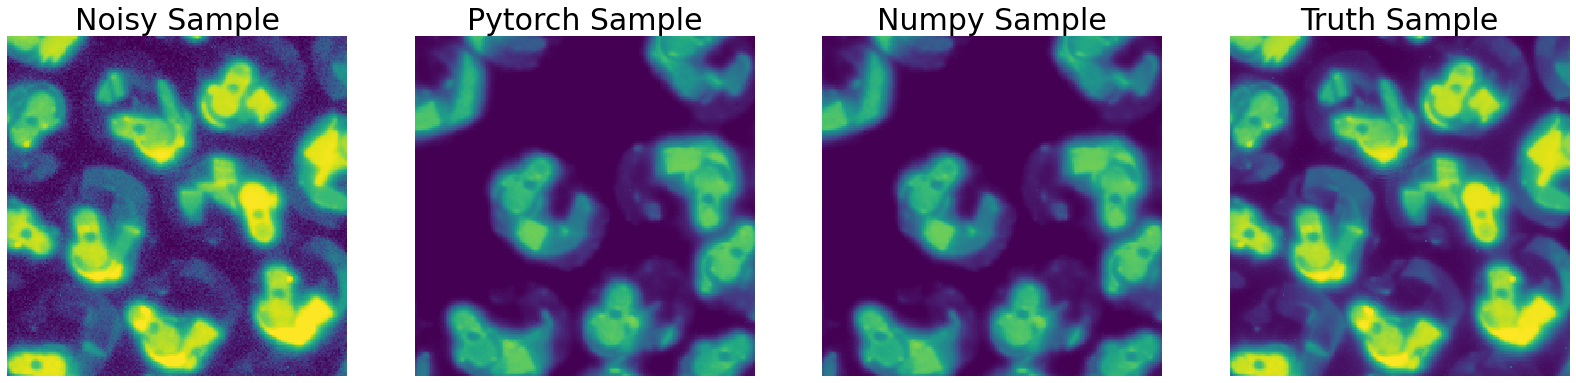

In [34]:
pytorch_numpy_comparison(raw_data=test_data,
                             pytorch_inf=pytorch_out,
                             numpy_inf=resid_img,
                             size=200,
                             start_idx=1400,
                             end_idx=1600)
#Noisy & truth samples are wrong because the pytorch and resid_img are only between 1000:3000, while
# the others are the full 6k by 6k. Change to fix this tomorrow.

In [24]:
np.allclose(full_c1[0][0][1000:3000, 1000:3000], resid_img)

False